In [19]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
import nltk
from textblob import TextBlob
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
df = pd.read_csv("tweets.csv")

In [7]:
def tokenize_tweets(text_series):
    '''
    Cleans + tokenizes Pandas series of strings from the Salem Witch dataset.
    
    Returns pandas series of lists of tokens
    '''
    tweet_regex = "[^a-z\s]"
    clean = text_series.str.lower() \
                       .str.replace(tweet_regex,
                                    " ",
                                    regex=True)

    stop = nltk.corpus.stopwords.words('english')

    tokenize = lambda text: [i for i in nltk.word_tokenize(text) if i not in stop]
    tokens = clean.apply(tokenize)
    return tokens

In [8]:
df['tokens'] = tokenize_tweets(df['tweet'])

In [9]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1442277789164466176,1442277789164466176,2021-09-26 18:59:55 CDT,2021-09-26,18:59:55,-500,25843801,lau56,"Larry Underwood: ""Taking A Stand Against Trump...",NaN,...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"[anti, vaxx, chronicles, smuggling, ivermectin..."
1,1442277711242678275,1441081536019767296,2021-09-26 18:59:37 CDT,2021-09-26,18:59:37,-500,1067245130,bigl62,LV,NaN,...,NaN,NaN,NaN,NaN,"[{'screen_name': 'sadlybradleytoo', 'name': 'G...",NaN,NaN,NaN,NaN,"[talkingttweets, sadlybradleytoo, davidstaples..."
2,1442277511208001536,1442277511208001536,2021-09-26 18:58:49 CDT,2021-09-26,18:58:49,-500,1250279783717429248,mariannedouce14,Marianne Doucette,NaN,...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"[explosive, india, state, million, people, dec..."
3,1442277465829691397,1442229048143273988,2021-09-26 18:58:38 CDT,2021-09-26,18:58:38,-500,1265033840,caz_sampson,Caz Sampson,NaN,...,NaN,NaN,NaN,NaN,"[{'screen_name': 'GeordiLaforgei', 'name': 'Ge...",NaN,NaN,NaN,NaN,"[geordilaforgei, docjohng, pierrekory, really,..."
4,1442277212955291652,1442277212955291652,2021-09-26 18:57:38 CDT,2021-09-26,18:57:38,-500,4114756575,traumagotchiv2,marcelle,NaN,...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"[alberta, editable, immunization, pdf, stupid,..."


In [10]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'tokens'],
      dtype='object')

In [11]:
df_small = df[['date', 'tweet', 'tokens']]

In [12]:
df_small.head()

,date,tweet,tokens
0,2021-09-26,Anti-vaxx Chronicles: Smuggling ivermectin int...,"[anti, vaxx, chronicles, smuggling, ivermectin..."
1,2021-09-26,@talkingttweets @sadlybradleytoo @DavidStaples...,"[talkingttweets, sadlybradleytoo, davidstaples..."
2,2021-09-26,Explosive! India State of 241 MILLION People D...,"[explosive, india, state, million, people, dec..."
3,2021-09-26,@GeordiLaforgei @DocJohnG @PierreKory Really i...,"[geordilaforgei, docjohng, pierrekory, really,..."
4,2021-09-26,"""alberta editable immunization pdf"" - a stupid...","[alberta, editable, immunization, pdf, stupid,..."


In [13]:
def get_tweet_sentiment(self, tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(self.clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [20]:
def senti(x):
    return TextBlob(x).sentiment.polarity  

df_small['senti_score'] = df_small['tweet'].apply(senti)

/var/folders/_f/cn7w2_g979z63x69nw9b3y_r0000gn/T/ipykernel_30737/2262727498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['senti_score'] = df_small['tweet'].apply(senti)


In [21]:
df_small.head()

,date,tweet,tokens,senti_score
0,2021-09-26,Anti-vaxx Chronicles: Smuggling ivermectin int...,"[anti, vaxx, chronicles, smuggling, ivermectin...",0.35
1,2021-09-26,@talkingttweets @sadlybradleytoo @DavidStaples...,"[talkingttweets, sadlybradleytoo, davidstaples...",0.05
2,2021-09-26,Explosive! India State of 241 MILLION People D...,"[explosive, india, state, million, people, dec...",0.00
3,2021-09-26,@GeordiLaforgei @DocJohnG @PierreKory Really i...,"[geordilaforgei, docjohng, pierrekory, really,...",0.08
4,2021-09-26,"""alberta editable immunization pdf"" - a stupid...","[alberta, editable, immunization, pdf, stupid,...",-0.65


In [22]:
df_grouped = df_small.groupby('date').mean()

<AxesSubplot:xlabel='date'>

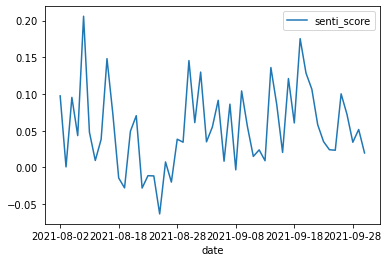

In [23]:
df_grouped.plot(use_index=True)